In [1]:
%pylab inline
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import sklearn.model_selection as selection
import sklearn.metrics as metrics
import sklearn.linear_model as linear
from sklearn import datasets
from sklearn.decomposition import PCA
from scipy.stats import ttest_rel
from sklearn import tree
import pandas as pd 

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\ProgramData\Anaconda3\envs\jade_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.columns

Index(['CCW', 'CCLNT', 'total len', 'Weight (Kg)', 'SpeciesName'], dtype='object')

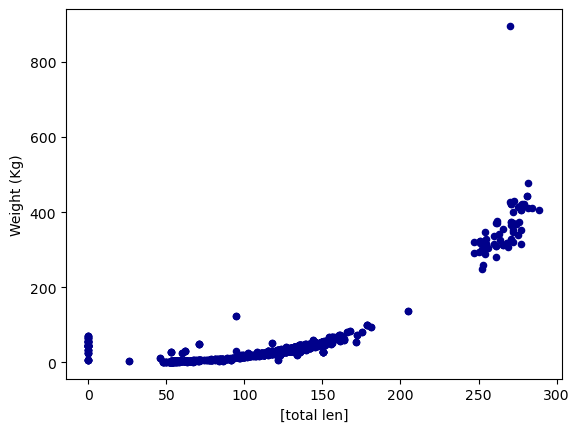

In [4]:
ax1 = df.plot.scatter(x=['total len'],y='Weight (Kg)',c='DarkBlue')

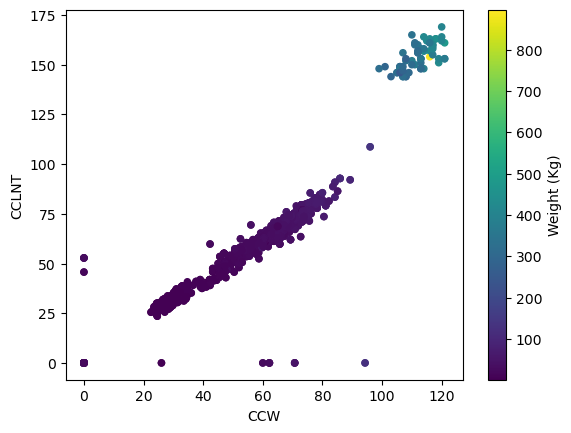

In [5]:
scatter = df.plot(x = 'CCW', y = 'CCLNT', kind = 'scatter', c = 'Weight (Kg)')

In [6]:
X = df[['CCW', 'CCLNT']].values
y = df[['Weight (Kg)']].values

In [7]:
print("size of X = ", X.size)
print("size of y = ", y.size)

size of X =  3976
size of y =  1988


In [8]:
X_train, X_test, y_train, y_test = selection.train_test_split(X, y, test_size=0.2, shuffle=True)

In [9]:
X_train.shape

(1590, 2)

In [10]:
mse = nn.MSELoss()

def loss_function(predictions, actual):
    return mse(predictions, actual)

In [11]:
type(X_train)

numpy.ndarray

In [12]:
class LinearRegression(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        w = th.tensor(np.random.random(size=n_features), dtype=th.float32)
        c = th.tensor(np.random.random(), dtype=th.float32)
        self.w = nn.Parameter(w)
        self.c = nn.Parameter(c)
    
    def predict(self, X):
        return  self.w @ th.transpose(X, 0, 1) + self.c
        #tensors stored as collection of rows
        # 1 X n (M X n)T + c)
        #1xn (n x M) + c
        # 1 x M
    
    # instead of saying model.predict(X)
    # this allows us to say model(X)
    def forward(self, X):
        return self.predict(X)
    
    def loss(self, X, y):
        predictions = self.predict(X)
        return loss_function(predictions, y)

In [13]:
model = LinearRegression(n_features=2)
lr = 0.01
optimizer = optim.RMSprop(model.parameters(), lr=lr)
num_iters = 1000
loss_curve = []

def plot_loss(loss_curve):
    plt.plot(list(range(len(loss_curve))), loss_curve)

In [14]:
X_train = th.tensor(X_train, dtype=th.float32)
y_train = th.tensor(y_train, dtype=th.float32)
for i in range(num_iters):
    optimizer.zero_grad()
    loss_value = model.loss(X_train, y_train)
    loss_curve.append(loss_value.data.item())
    loss_value.backward()
    optimizer.step()

c:\ProgramData\Anaconda3\envs\jade_env\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1590, 1])) that is different to the input size (torch.Size([1590])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


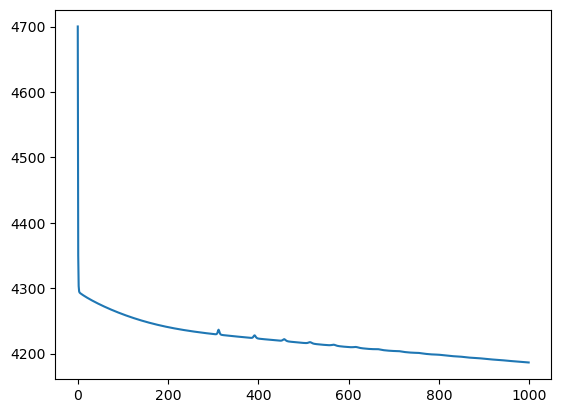

In [15]:
plot_loss(loss_curve)

# Basis Transformation

In [16]:
kf = selection.KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X)

5

In [17]:
mse = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr = linear.LinearRegression()
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_test)
    error = metrics.mean_squared_error(y_test, predictions)
    mse.append(error)
print('Average mse is ', np.mean(mse))

Average mse is  1394.797612219993


In [18]:
def basis_transform(X):
    phi_1 = X
    phi_2 = X ** 2
    phi_3 = X ** 3
    X_new = np.concatenate(tuple([phi_1, phi_2, phi_3]), axis=1)
    return X_new

In [19]:
kf = selection.KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X)
mse_original = []
mse_basis = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    lr = linear.LinearRegression() 
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_test)
    error = metrics.mean_squared_error(y_test, predictions)
    mse_original.append(error)
    
    lr2 = linear.LinearRegression()
    X_train = basis_transform(X_train)
    X_test = basis_transform(X_test)
    lr2.fit(X_train, y_train)
    predictions = lr2.predict(X_test)
    error = metrics.mean_squared_error(y_test, predictions)
    mse_basis.append(error)
    
print('Average mse for original is ', np.mean(mse_original))
print('Average mse for basis transformed  is ', np.mean(mse_basis))

Average mse for original is  1434.6680071804599
Average mse for basis transformed  is  213.29367255915093


In [20]:
X.size, y.size

(3976, 1988)